### EconML

In [2]:
import pandas as pd
import numpy as np
import psutil
from econml.iv.dr import DRIV, SparseLinearDRIV, ForestDRIV, LinearDRIV
from matplotlib import pyplot as plt
from joblib import Parallel, delayed # for parallel processing
import seaborn as sns

In [3]:
# Get the virtual memory details
memory_info = psutil.virtual_memory()
total_memory = memory_info.total
available_memory = memory_info.available
used_memory = memory_info.used

print(f"Total Memory: {total_memory / (1024 ** 3):.2f} GB")
print(f"Available Memory: {available_memory / (1024 ** 3):.2f} GB")
print(f"Used Memory: {used_memory / (1024 ** 3):.2f} GB")

Total Memory: 7.45 GB
Available Memory: 0.94 GB
Used Memory: 6.51 GB


In [4]:
df = pd.read_csv("./Final Data/analysis_input3.csv")
df = df.dropna(subset=['overlap']).dropna()

In [5]:
df = df[df['mergerID']!=9]

In [6]:
df['branch_closures_tract_binary'] = [1 if x>0 else 0 for x in df['branch_closures_tract'] ]

In [7]:
# Define the winsorization function
def winsorize_column(df, column, lower_percentile=0.025, upper_percentile=0.975):
    lower_bound = df[column].quantile(lower_percentile)
    upper_bound = df[column].quantile(upper_percentile)
    df[column] = df[column].clip(lower=lower_bound, upper=upper_bound)
    return df

# Apply winsorization on 'mortgage' and 'sbl_total'
df = winsorize_column(df, 'mortgage', 0.01, 0.99)
df = winsorize_column(df, 'sbl_total', 0.01, 0.99)

In [8]:
# Step 2: Create event_year variable
df['event_year'] = df['year'] - df['EFFDATE']

# Step 3: Preserve, then generate close_2yr
df['close_2yr'] = 0
df.loc[((df['event_year'] == 0) |(df['event_year'] == 1)), 'close_2yr'] = df['branch_closures_tract_binary'] #(df['event_year'] == 0) | 

# Collapse (taking max of 'close_2yr') and group by relevant columns
df_collapsed = df.groupby(['state', 'county', 'tract', 'overlap', 'mergerID']).agg({'close_2yr': 'max'}).reset_index()
tempclose2 = df_collapsed.copy()
# Merge the collapsed dataframe back into the original one
df.drop(columns=['close_2yr'], inplace=True)
df = df.merge(tempclose2, on=['state', 'county', 'tract', 'overlap', 'mergerID'], how='left')

In [9]:
# Step 4: Generate POST, POST_close, and POST_expose variables
df['POST'] = (df['event_year'] > 0).astype(int)
df['POST_close'] = df['POST'] * df['close_2yr']
df['POST_expose'] = df['POST'] * df['overlap']

# Step 4: Generate year dummies (ydum1999 to ydum2013)
for year in range(2010, 2023):
    df[f'ydum{year}'] = (df['year'] == year).astype(int)
    
# Step 5: Interact control variables with year dummies
control_vars = ['poptot', 'popden', 'pminority', 'pcollege', 'medincome', 'total_branches_county', 'avg_branch_growth_county']


# Step 7: Create group variables
df['group_timeID'] = pd.Categorical(pd.factorize(df[['state', 'county', 'year']].apply(tuple, axis=1))[0])
df['indivID'] = pd.Categorical(pd.factorize(df[['state', 'county', 'tract']].apply(tuple, axis=1))[0])
df['clustID'] = pd.Categorical(pd.factorize(df[['state', 'county']].apply(tuple, axis=1))[0])

In [10]:
def demean(df, group_vars, vars_to_demean):
    """
    Demean variables by group variables (fixed effects).
    
    Args:
        df (pd.DataFrame): The dataframe containing the data.
        group_vars (list of str): List of column names representing the fixed effect variables.
        vars_to_demean (list of str): List of variables to demean.
        
    Returns:
        df_demeaned (pd.DataFrame): DataFrame with demeaned variables.
    """
    df_demeaned = df.copy()
    
    # Group by the fixed effect variables and calculate group means
    group_means = df.groupby(group_vars, observed=True)[vars_to_demean].transform('mean')
    
    # Subtract the group means from the original variables to demean
    df_demeaned[vars_to_demean] = df[vars_to_demean] - group_means
    
    return df_demeaned

In [11]:
# List of variables to demean (dependent variable, endogenous variable, exogenous variables)
vars_to_demean = ['sbl_total', 'vol_sbus', 'sbl_total_num', 'num_sbus', 'mortgage'] + control_vars


# Demean the dataset by indivID and group_timeID
df_demeaned = demean(df, 'indivID', vars_to_demean)

df_final = demean(df_demeaned, 'group_timeID', vars_to_demean)

In [12]:
df_dowhy = df_final.dropna(subset = ['branch_closures_tract', 'total_branches_tract', 'sbl_total', 'POST_close', 'POST_expose'] + control_vars)

In [13]:
np.random.seed(88)

y = df_dowhy["sbl_total"] #branch_closures_tract
T = df_dowhy["POST_close"]
I = df_dowhy['POST_expose']
X = df_dowhy[control_vars]

treated_group = df_dowhy[df_dowhy['POST_close'] == 1][control_vars]
control_group = df_dowhy[df_dowhy['POST_close'] == 0][control_vars]

In [14]:
def boot_models(model_choice, y, T, I, X):
    #scaler = StandardScaler()
    #X_scaled = scaler.fit_transform(X)
    
    est = model_choice(discrete_treatment=True, discrete_instrument=True)

    est.fit(Y = y, T = T, Z = I, X = X)

    return est.effect(treated_group).mean() - est.effect(control_group).mean()

In [15]:
def plot_ate_CI(ates):
    print(f"ATE: {ates.mean()}")
    print(f"95% C.I.: {(np.percentile(ates, 2.5), np.percentile(ates, 97.5))}")
    sns.distplot(ates, kde=False)
    plt.vlines(np.percentile(ates, 2.5), 0, 30, linestyles="dotted")
    plt.vlines(np.percentile(ates, 97.5), 0, 30, linestyles="dotted", label="95% CI")
    plt.title("LATE Bootstrap Distribution")
    plt.legend()

In [16]:
bootstrap_sample = 1000

In [16]:
atesDRIV = Parallel(n_jobs=6)(delayed(boot_models)(DRIV, y, T, I, X.sample(frac=1, replace=True))
                        for _ in range(bootstrap_sample))
atesDRIV = np.array(atesDRIV)

ATE: -100.5147387737434
95% C.I.: (-4751.659921111335, 4991.180866219006)




`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



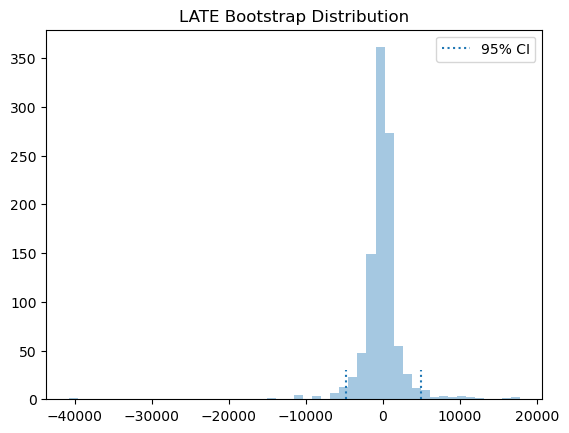

In [23]:
plot_ate_CI(atesDRIV)

In [17]:
atesLinearDRIV = Parallel(n_jobs=6)(delayed(boot_models)(LinearDRIV, y, T, I, X.sample(frac=1, replace=True))
                        for _ in range(bootstrap_sample))
atesLinearDRIV = np.array(atesLinearDRIV)

ATE: 271.3421546102161
95% C.I.: (-4945.165767518642, 6546.687670153992)




`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



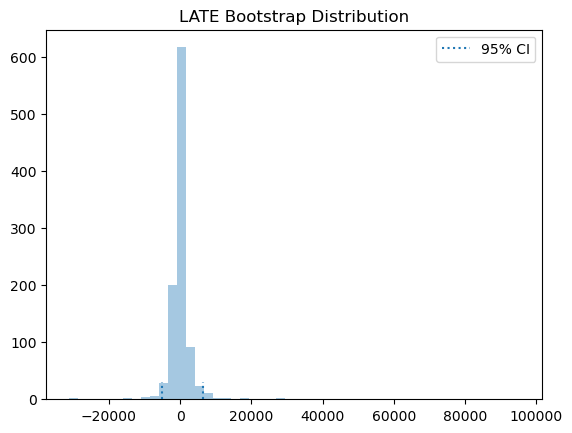

In [18]:
plot_ate_CI(atesLinearDRIV)

In [20]:
atesForestDRIV = Parallel(n_jobs=6)(delayed(boot_models)(ForestDRIV, y, T, I, X.sample(frac=1, replace=True))
                        for _ in range(bootstrap_sample))
atesForestDRIV = np.array(atesForestDRIV)

In [19]:
plot_ate_CI(atesForestDRIV)

NameError: name 'atesForestDRIV' is not defined